# Interpreting Machine Learning and Deep Learning Models on Text Data

We will look at explaining linear models like Logistic Regression and complex deep learning models like LSTMs trained on unstructured text data using SHAP values

# Load Dependencies

In [1]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
import model_evaluation_utils as meu
import shap
import warnings
warnings.filterwarnings('ignore')

shap.initjs()

# Load IMDB Reviews Dataset Sample

In [2]:
corpus, labels = shap.datasets.imdb()
labels = ['Positive' if label else 'Negative' for label in labels]
len(corpus), len(labels)

(25000, 25000)

In [3]:
corpus[3], labels[4]

('Sorry everyone,,, I know this is supposed to be an "art" film,, but wow, they should have handed out guns at the screening so people could blow their brains out and not watch. Although the scene design and photographic direction was excellent, this story is too painful to watch. The absence of a sound track was brutal. The loooonnnnng shots were too long. How long can you watch two people just sitting there and talking? Especially when the dialogue is two people complaining. I really had a hard time just getting through this film. The performances were excellent, but how much of that dark, sombre, uninspired, stuff can you take? The only thing i liked was Maureen Stapleton and her red dress and dancing scene. Otherwise this was a ripoff of Bergman. And i\'m no fan f his either. I think anyone who says they enjoyed 1 1/2 hours of this is,, well, lying.\n',
 'Negative')

In [4]:
corpus_train, corpus_test, y_train, y_test = train_test_split(np.array(corpus), np.array(labels), 
                                                              test_size=0.2, random_state=42)
corpus_train.shape, corpus_test.shape, y_train.shape, y_test.shape

((20000,), (5000,), (20000,), (5000,))

# Basic Text Pre-processing

In [5]:
import contractions
from bs4 import BeautifulSoup
import unicodedata
import re
from concurrent import futures
import threading


def strip_html_tags(text):
    soup = BeautifulSoup(text, "lxml")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text, re.I)
    return stripped_text


def remove_urls(text):
    url_pattern = '((https?:\/\/)(\s)*(www\.)?|(www\.))(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*'
    text = re.sub(url_pattern, ' ', text, re.I)
    return text


def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text


def expand_contractions(text):
    return contractions.fix(text)


def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9/\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, ' ', text)
    return text


def pre_process_document(document):
    # strip HTML
    document = strip_html_tags(document)

    # remove URLS
    document = remove_urls(document)

    # expand contractions
    document = expand_contractions(document)

    # lower case
    document = document.lower()

    # remove extra newlines (often might be present in really noisy text)
    document = document.translate(document.maketrans("\n\t\r", "   "))

    # remove accented characters
    document = remove_accented_chars(document)

    # remove special characters and\or digits
    # insert spaces between special characters to isolate them
    special_char_pattern = re.compile(r'([{.(-)!}])')
    document = special_char_pattern.sub(" \\1 ", document)
    document = remove_special_characters(document, remove_digits=False)

    # remove only numbers
    document = re.sub(r'\b\d+\b', '', document)

    # remove extra whitespace
    document = re.sub(' +', ' ', document)
    document = document.strip()

    return document


def parallel_preprocessing(idx, doc, total_docs):
    if idx % 5000 == 0 or idx == (total_docs - 1):
        print('{}: working on doc num: {}'.format(threading.current_thread().name,
                                                  idx)
    )
    return pre_process_document(doc)


def pre_process_documents_parallel(documents):
    total_docs = len(documents)
    docs_input = [[idx, doc, total_docs] for idx, doc in enumerate(documents)]
    
    ex = futures.ThreadPoolExecutor(max_workers=None)
    print('preprocessing: starting')
    norm_descriptions_map = ex.map(parallel_preprocessing, 
                                   [record[0] for record in docs_input],
                                   [record[1] for record in docs_input],
                                   [record[2] for record in docs_input])
    norm_descriptions = list(norm_descriptions_map)
    return norm_descriptions

In [6]:
corpus_train = pre_process_documents_parallel(corpus_train)
corpus_test = pre_process_documents_parallel(corpus_test)

preprocessing: starting
ThreadPoolExecutor-0_0: working on doc num: 0
ThreadPoolExecutor-0_4: working on doc num: 5000
ThreadPoolExecutor-0_12: working on doc num: 10000
ThreadPoolExecutor-0_11: working on doc num: 15000
ThreadPoolExecutor-0_5: working on doc num: 19999
preprocessing: starting
ThreadPoolExecutor-1_0: working on doc num: 0
ThreadPoolExecutor-1_4: working on doc num: 4999


# Extract TF-IDF Features

In [7]:
vectorizer = TfidfVectorizer(min_df=0.005, max_df=0.98, stop_words=None)
X_train = vectorizer.fit_transform(corpus_train)
X_test = vectorizer.transform(corpus_test)
X_train.shape

(20000, 3161)

In [8]:
import pandas as pd

pd.DataFrame(X_train.toarray(), columns=list(vectorizer.get_feature_names())).head(10)

,60s,70s,80s,abandoned,ability,able,about,above,absolute,absolutely,...,york,you,young,younger,your,yourself,youth,zero,zombie,zombies
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.188569,0.0,0.0,0.162901,0.127366,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.036310,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.053352,0.000000,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.041119,0.0,0.0,0.000000,0.111094,0.0,0.000000,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.088485,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.031655,0.0,0.0,0.065856,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.090537,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.075119,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.094266,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0


# Build a Logistic Regression Classifier

In [9]:
model = sklearn.linear_model.LogisticRegression(C=10)
model.fit(X_train, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [10]:
y_pred = model.predict(X_test)
y_pred

array(['Negative', 'Positive', 'Negative', ..., 'Negative', 'Positive',
       'Negative'], dtype='<U8')

In [11]:
meu.display_model_performance_metrics(true_labels=y_test, predicted_labels=y_pred,
                                      classes=list(set(y_test)))

Model Performance metrics:
------------------------------
Accuracy: 0.8736
Precision: 0.8736
Recall: 0.8736
F1 Score: 0.8736

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    Positive       0.87      0.87      0.87      2485
    Negative       0.87      0.88      0.87      2515

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   Positive Negative
Actual: Positive       2166      319
        Negative        313     2202


# Model Interpretation with SHAP

Note that with a linear model the SHAP value for feature i for the prediction $f(x)$ (assuming feature independence) is just $\phi_i = \beta_i \cdot (x_i - E[x_i])$. Since we are explaining a logistic regression model the units of the SHAP values will be in the log-odds space.

In [12]:
explainer = shap.LinearExplainer(model, X_train, nsamples=20000)
shap_values = explainer.shap_values(X_test)[0]

In [13]:
np.round(shap_values, 5), shap_values.shape

(array([[ 0.00108,  0.00146,  0.00072, ..., -0.00017, -0.00286,  0.00362],
        [ 0.00108,  0.00146,  0.00072, ..., -0.00017, -0.00286,  0.00362],
        [ 0.00108,  0.00146,  0.00072, ..., -0.00017, -0.00286,  0.00362],
        ...,
        [ 0.00108,  0.00146,  0.00072, ..., -0.00017, -0.00286,  0.00362],
        [ 0.00108,  0.00146,  0.00072, ..., -0.00017, -0.00286,  0.00362],
        [ 0.00108,  0.00146,  0.00072, ..., -0.00017, -0.00286,  0.00362]]),
 (5000, 3161))

In [14]:
X_test_arr = X_test.toarray()

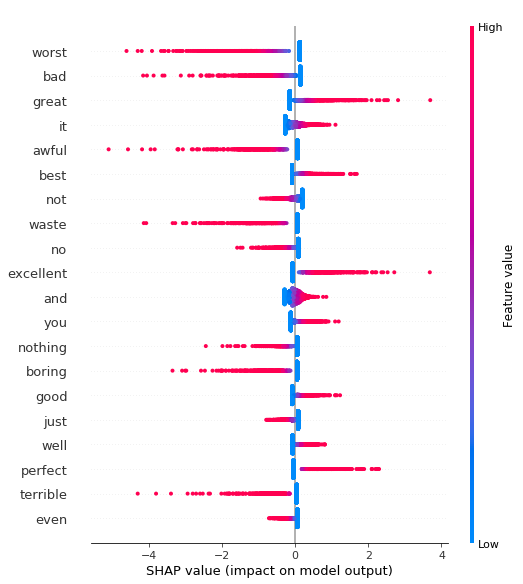

In [15]:
shap.summary_plot(shap_values, X_test_arr, feature_names=vectorizer.get_feature_names())

In [16]:
expected_value = np.asarray(explainer.expected_value)[0][0]
expected_value

-0.18560994585054819

In [17]:
ind = 9
print('Review:', corpus_test[ind])
print('Actual:', y_test[ind])
print('Predicted:', y_pred[ind])
shap.force_plot(
    expected_value, shap_values[ind,:], X_test_arr[ind,:],
    feature_names=vectorizer.get_feature_names(), figsize=(30, 3)
)

Review: mr perlman gives a standout performance as usual sadly he has to struggle with an underwritten script and some nonsensical set pieces larsen is in die hard mode complete with singlet and bulging muscles i am sure he could do better but seems satisfied to grimace and snarl through his part the lovely erika is very decorative even though fully clothed and shows some signs of getting acting at last sfx are mainly poor cgi and steals from other movies the shootouts are pitiful worthy of the a teamnot even worth seeing for perlman avoid
Actual: Negative
Predicted: Negative


In [18]:
ind = 13
print('Review:', corpus_test[ind])
print('Actual:', y_test[ind])
print('Predicted:', y_pred[ind])
shap.force_plot(
    expected_value, shap_values[ind,:], X_test_arr[ind,:],
    feature_names=vectorizer.get_feature_names()
)

Review: this i think is one of the best pictures ever made it is so pure and beautiful it really touched me i am glad david lynch proved that a film does not necessarily need sfx a twisting complicated plot or flashy images way to go dave i would like to see cronenberg do that
Actual: Positive
Predicted: Positive


# Build a Stacked LSTM Deep Learning Classifier

In [19]:
import keras

Using TensorFlow backend.


In [20]:
tokenizer = keras.preprocessing.text.Tokenizer(oov_token='<UNK>', num_words=None)
tokenizer.fit_on_texts(corpus_train)
tokenizer.word_index['<PAD>'] = 0

In [21]:
MAX_FEATURES = len(tokenizer.word_index)
DOC_LEN = 1000
EMBED_SIZE = 300
MAX_FEATURES

68642

In [22]:
train_X = tokenizer.texts_to_sequences(corpus_train)
test_X = tokenizer.texts_to_sequences(corpus_test)

train_X = keras.preprocessing.sequence.pad_sequences(train_X, maxlen=DOC_LEN)
test_X = keras.preprocessing.sequence.pad_sequences(test_X, maxlen=DOC_LEN)

train_X.shape, test_X.shape

((20000, 1000), (5000, 1000))

In [23]:
inp = keras.layers.Input(shape=(DOC_LEN,))
x = keras.layers.Embedding(MAX_FEATURES, EMBED_SIZE, trainable=True)(inp)
x = keras.layers.CuDNNLSTM(128, return_sequences=True)(x)
x = keras.layers.CuDNNLSTM(64, return_sequences=False)(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dropout(rate=0.3)(x)
x = keras.layers.Dense(32, activation='relu')(x)
x = keras.layers.Dropout(rate=0.4)(x)
outp = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.models.Model(inputs=inp, outputs=outp)

model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=5e-5), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 300)         20592600  
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 1000, 128)         220160    
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 64)                49664     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
__________

In [24]:
y_train_enc = [1 if item == 'Positive' else 0 for item in y_train]
y_test_enc = [1 if item == 'Positive' else 0 for item in y_test]

In [25]:
model.fit(train_X, y_train_enc,
          batch_size=36,
          epochs=3,
          validation_split=0.1, verbose=1)

Train on 18000 samples, validate on 2000 samples
Epoch 1/3
18000/18000 [==============================] - 59s 3ms/step - loss: 0.6400 - acc: 0.6125 - val_loss: 0.4535 - val_acc: 0.7900
Epoch 2/3
18000/18000 [==============================] - 55s 3ms/step - loss: 0.3534 - acc: 0.8637 - val_loss: 0.3405 - val_acc: 0.8445
Epoch 3/3
18000/18000 [==============================] - 55s 3ms/step - loss: 0.2119 - acc: 0.9297 - val_loss: 0.3142 - val_acc: 0.8715


In [26]:
y_pred = model.predict(test_X, batch_size=1000, verbose=1)
y_pred = y_pred.ravel()
y_pred = ['Positive' if prob > 0.5 else 'Negative' for prob in y_pred]

5000/5000 [==============================] - 2s 364us/step


In [27]:
meu.display_model_performance_metrics(true_labels=y_test, predicted_labels=y_pred,
                                      classes=list(set(y_test)))

Model Performance metrics:
------------------------------
Accuracy: 0.8814
Precision: 0.8828
Recall: 0.8814
F1 Score: 0.8813

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    Positive       0.91      0.85      0.88      2485
    Negative       0.86      0.91      0.89      2515

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   Positive Negative
Actual: Positive       2111      374
        Negative        219     2296


# Model Interpretation using Deep SHAP

Deep SHAP is a high-speed approximation algorithm for SHAP values in deep learning models that builds on a connection with DeepLIFT.

### What is DeepLIFT?

The purported “black box” nature of neural networks is a barrier to adoption in applications where interpretability is essential. 

DeepLIFT (Deep Learning Important FeaTures), a method for decomposing the output prediction of a neural network on a specific input by backpropagating the contributions of all neurons in the network to every feature of the input. 

DeepLIFT compares the activation of each neuron to its ‘reference activation’ and assigns contribution scores according to the difference. 

By optionally giving separate consideration to positive and negative contributions, DeepLIFT can also reveal dependencies which are missed by other approaches. Scores can be computed efficiently in a single backward pass.


### How is Deep SHAP different?

The implementation here differs from the original DeepLIFT by using a distribution of background samples instead of a single reference value, and using Shapley equations to linearize components such as max, softmax, products, divisions, etc. 

In [30]:
explainer = shap.DeepExplainer(model, train_X[:500])

In [31]:
shap_values = explainer.shap_values(test_X[:15])[0]

In [35]:
expected_value = explainer.expected_value[0]
expected_value

0.48906058

In [ ]:
x_test_words = np.stack([np.array(list(map(lambda x: num2word.get(x, "NONE"), x_test[i]))) for i in range(10)])

In [33]:
idx2word = {v:k for k, v in tokenizer.word_index.items()}
token_mapper = lambda token: idx2word.get(token, '<UNK>')

In [45]:
ind = 9
print('Review:', corpus_test[ind])
print('Actual:', y_test[ind])
print('Predicted:', y_pred[ind])
shap.force_plot(expected_value, shap_values[ind], list(map(token_mapper, test_X[ind])))

Review: mr perlman gives a standout performance as usual sadly he has to struggle with an underwritten script and some nonsensical set pieces larsen is in die hard mode complete with singlet and bulging muscles i am sure he could do better but seems satisfied to grimace and snarl through his part the lovely erika is very decorative even though fully clothed and shows some signs of getting acting at last sfx are mainly poor cgi and steals from other movies the shootouts are pitiful worthy of the a teamnot even worth seeing for perlman avoid
Actual: Negative
Predicted: Negative


In [46]:
ind = 13
print('Review:', corpus_test[ind])
print('Actual:', y_test[ind])
print('Predicted:', y_pred[ind])
shap.force_plot(expected_value, shap_values[ind], list(map(token_mapper, test_X[ind])))

Review: this i think is one of the best pictures ever made it is so pure and beautiful it really touched me i am glad david lynch proved that a film does not necessarily need sfx a twisting complicated plot or flashy images way to go dave i would like to see cronenberg do that
Actual: Positive
Predicted: Positive


Note that each sample is an IMDB review text document, represented as a sequence of words. This means "feature 0" is the first word in the review, which will be different for difference reviews. This means calling summary_plot will combine the importance of all the words by their position in the text. This is likely not what you want for a global measure of feature importance (which is why we have not called summary_plot here). If you do want a global summary of a word's importance you could pull apart the feature attribution values and group them by words.